In [3]:
import itertools
import math
import random 
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.special import comb

def sample_spherical(npoints, ndim):#sample points on the sphere
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec
def harmonic_eigespcDim(d,l):#spherical harmonics dimensions
    return comb(l+d-1,l)-comb(l+d-3,l-2)
def cluster_esp1(eigvals, dim_esp1):#cluster algorithm
    actualpoint=0
    gap=0
    for i in range(1,len(eigvals)-dim_esp1-1):
        vi=np.abs(eigvals[i]-eigvals[i-1])
        vii=np.abs(eigvals[i+dim_esp1]-eigvals[i+dim_esp1-1])
        g=min(vi,vii)
        if g>=gap:
            gap=g
            actualpoint=i
    if np.abs(eigvals[len(eigvals)-dim_esp1]-eigvals[len(eigvals)-dim_esp1-1])>=gap:
        gap=g
        actualpoint=len(eigvals)-dim_esp1
    return [actualpoint,gap]
def estimator_Gram(arrayEigvec,dimEigspc,firsteig):
    rr=np.zeros((len(arrayEigvec[:,0]),len(arrayEigvec[:,0])))
    if dimEigspc+firsteig<len(arrayEigvec[:,0]):
        for i in range(firsteig,dimEigspc+firsteig):
            rr=rr+np.outer(arrayEigvec[:,i],arrayEigvec[:,i])
    return rr
@np.vectorize
def funcexample1(x):#classic angular RGG
    y=0
    if x>=0:
        y=1
    return y 

In [4]:
#Algorithm HEiC example 
npoints=100#sample size
rho_n=1# definition scale parameter 
d=3#sphere dimension
X=sample_spherical(npoints,d)
Gr=np.matmul(np.transpose(X),X) #This is the Gram matrix of the sample points
Theta=rho_n*funcexample1(Gr)
Theta[Theta<0]=0
Theta[Theta>1]=1 #just to avoid rounding problems 
Ber=np.random.binomial(1,Theta)
Graph=np.triu(Ber)+np.transpose(np.triu(Ber))-np.eye(npoints)
normGraph=(1/npoints)*Graph
eigvalGraph,eigvecGraph=LA.eig(normGraph)
eigvalGraph=np.real(eigvalGraph)
eigvecGraph=np.real(eigvecGraph)
idx = eigvalGraph.argsort()[::-1]   
eigenValues = eigvalGraph[idx] #sort the eigenvalues
eigenVectors = eigvecGraph[:,idx]
[actual,gapo]=cluster_esp1(eigenValues, d)#subspace recovery
space1dim=int(harmonic_eigespcDim(d,1))
estMatGram=estimator_Gram(eigenVectors,d,actual)
scal1_estMatGram=(npoints/space1dim)*estMatGram 
np.fill_diagonal(scal1_estMatGram,1)
meanError=LA.norm(Gr-scal1_estMatGram)/npoints**2 #mean error with the Frobenius norm--other norms possible, see numpy.linalg.norm doc


In [8]:
#Example to generate errorboxplot
d=3
ranges=20
npointsv=np.array([10,50,100,200,500,1000,2000])#,5000,10000])#put there the samples sizes we want to iterate
Err1=np.zeros((ranges,len(npointsv)))
vareigen=np.zeros(2000)
count=0
for npoints in npointsv:
    cicles=0
    for i in range(0,ranges):
        X=sample_spherical(npoints,d)
        Gr=np.matmul(np.transpose(X),X) #This is the Gram matrix of the sample points #Theta=poly(funcs,Gr)
        Theta=funcexample1(Gr)
        Theta[Theta<0]=0
        Theta[Theta>1]=1 
        Ber=np.random.binomial(1,Theta)
        Graph=np.triu(Ber)+np.transpose(np.triu(Ber))-np.eye(npoints)
        normGraph=(1/npoints)*Graph
        eigvalGraph,eigvecGraph=LA.eig(normGraph)
        eigvalGraph=np.real(eigvalGraph)
        eigvecGraph=np.real(eigvecGraph)
        idx = eigvalGraph.argsort()[::-1]   
        eigenValues = eigvalGraph[idx]
        eigenVectors = eigvecGraph[:,idx]
        [actual,gapo]=cluster_esp1(eigenValues,d)
        estMatGram=estimator_Gram(eigenVectors,d,actual)
        scal1_estMatGram=(npoints/d)*estMatGram #scaling by the formula 
        np.fill_diagonal(scal1_estMatGram,1)#change diagonal values to 1
        meanError2=LA.norm(Gr-scal1_estMatGram)/npoints**2
        Err1[i,count]=meanError2#**2
        vareigen[0+cicles:d+cicles]=eigenValues[1:d+1]
        cicles=cicles+1
    count=count+1

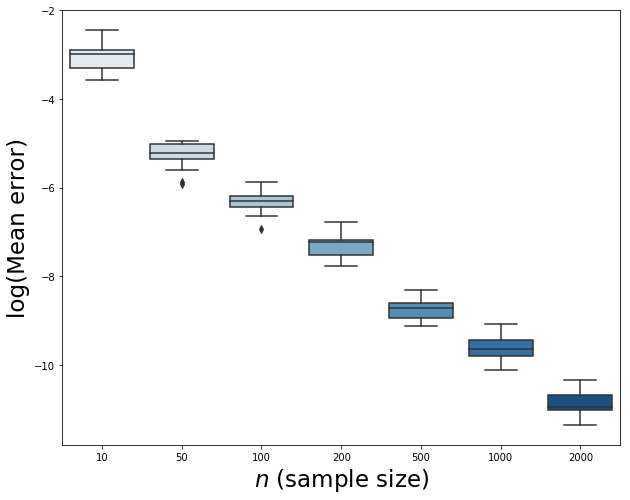

In [10]:
import matplotlib.patches as mpatches
import pandas as pd
#equation = 'log(MSE(n))= ' + 'log'+str(1.1) + '+' + str(2.87)+'x' 'log n'
#df = pd.DataFrame(data=np.log(Er2[0:25]))
df = pd.DataFrame(data=np.log(Err1))
df.columns= ['10','50','100','200','500','1000','2000']#,'5000','10000']
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(ax=ax, data=df,palette="Blues")
ax.set_xlabel("$n$ (sample size)",fontsize=23)
ax.set_ylabel("log(Mean error)",fontsize=23)
##plt.plot(ix,y,'r')
#ax.set(xlabel='$n$ (sample size)',ylabel='log(Mean error)')
#plt.text(0.8, 0.9,equation, horizontalalignment='center',
   #  verticalalignment='center',
   #  transform=ax.transAxes)
##red_patch = mpatches.Patch(color='red', label=equation)
##plt.legend(handles=[red_patch],prop={'size': 17})

plt.show()

In [11]:
#Dimension recovery 
npoints=1000
maxiter=30
dmax=20
Gap=np.zeros((maxiter,dmax))
for aux in range(0,maxiter):
    d=3#d to generate data
    X=sample_spherical(npoints,d)
    Gr=np.matmul(np.transpose(X),X) #This is the Gram matrix of the sample points
    Theta=funcexample1(Gr) #the probability matrix....
    Theta[Theta<0]=0
    Theta[Theta>1]=1 #this step can be replaced by a preprocesing---To be done---
    Ber=np.random.binomial(1,Theta)
    Graph=np.triu(Ber)+np.transpose(np.triu(Ber))#-np.eye(npoints)
    normGraph=(1/npoints)*Graph
    eigvalGraph,eigvecGraph=LA.eig(normGraph)
    eigvalGraph=np.real(eigvalGraph)
    eigvecGraph=np.real(eigvecGraph)
    idx = eigvalGraph.argsort()[::-1]   
    eigenValues = eigvalGraph[idx]
    eigenVectors = eigvecGraph[:,idx]
    DS=np.zeros(dmax)
    for dd in range(1,dmax-1):
        [actual,gapo]=cluster_esp1(eigenValues, dd)
        DS[dd]=gapo
        Gap[aux,dd]=gapo
        

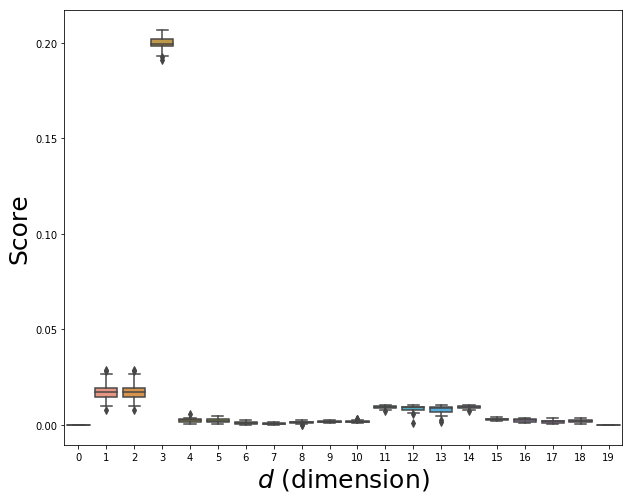

In [12]:
#to generate plot for dimension recovery
df = pd.DataFrame(data=Gap)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(ax=ax, data=df)
ax.set_xlabel("$d$ (dimension)",fontsize=25)
ax.set_ylabel("Score",fontsize=25)
plt.show()